In [14]:
import os
import ase
import torch
from copy import deepcopy
from tqdm import tqdm
import numpy as np
from ase.io import Trajectory
from ase.visualize import view
import nglview as nv
import ipywidgets
from ase.neighborlist import natural_cutoffs, NeighborList
from fairchem.core.datasets import LmdbDataset
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pylab as pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scienceplots
from math import floor, log10
from matplotlib import rc
from mace.calculators import mace_off
plt.style.use(['science','no-latex'])

params = {'figure.dpi': 900,
            'axes.labelsize': 'small',
          'legend.fontsize': 'x-small',
         'axes.titlesize':'medium',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.family': 'DejaVu Sans'}

pylab.rcParams.update(params)

data_dir = "/data/shared/ishan_stuff/spice_separated"
checkpoint_dir = "/data/shared/ishan_stuff/student_checkpoints/spice"
md_dir = "2024-09-05-00-08-48-monomers-gemSmall"
traj = Trajectory(os.path.join(checkpoint_dir, md_dir, "md_system10.traj"))

nv.show_asetraj(traj)


NGLWidget(max_frame=79846)

In [27]:
# Adapted from https://github.com/kyonofx/MDsim/blob/main/observable.ipynb

def distance_pbc(x0, x1, lattices):
    delta = torch.abs(x0 - x1)
    lattices = lattices.view(-1,1,3)
    delta = torch.where(delta > 0.5 * lattices, delta - lattices, delta)
    return torch.sqrt((delta ** 2).sum(dim=-1))

def dir_to_legend_name(md_dir):
    name = ""
    if "gem" in md_dir.lower():
        name += "GemNet-dT "
    elif "painn" in md_dir.lower():
        name += "PaiNN "
    
    if "dist" in md_dir.lower():
        name += "Distilled"
    else:
        name += "Undistilled"
    return name

def get_thermo(filename):
    """
    read thermo logs.
    """
    with open(filename, 'r') as f:
        thermo = f.read().splitlines()
        sim_time, Et, Ep, Ek, T = [], [], [], [], []
        for i in range(1, len(thermo)):
            try:
                t, Etot, Epot, Ekin, Temp = [float(x) for x in thermo[i].split(' ') if x]
                sim_time.append(t)
                Et.append(Etot)
                Ep.append(Epot)
                Ek.append(Ekin)
                T.append(Temp)
            except:
                sim_time, Et, Ep, Ek, T = [], [], [], [], []
    thermo = {
        'time': sim_time,
        'Et': Et,
        'Ep': Ep,
        'Ek': Ek,
        'T': T
    }
    return thermo
    
def plot_stability(data_split, md_dirs):
    # First figure: Bond length deviation over time
    plt.figure()

    # Remove axis ticks from the top and right borders
    plt.tick_params(top = False)
    plt.tick_params(right = False)

    # Reduce font size of the axis number labels (tick labels)
    plt.tick_params(axis='both', which='major', labelsize=10)  # Adjust size as needed

    
    plt.xlabel("Simulation time (picoseconds)", fontsize=11)
    plt.ylabel("Max bond length deviation (A)", fontsize=10)
    plt.axhline(stability_threshold, c='r', label="Stability Threshold")
    plt.yscale('log')

    teacher_calc = mace_off(model="large", dispersion=False, default_dtype="float32", device='cuda')

    # Prepare lists to hold teacher energies for the second figure
    all_teacher_energies = []
    labels = []

    for i, md_dir in enumerate(md_dirs):
        try:
            traj = Trajectory(os.path.join(checkpoint_dir, md_dir, "equilibration10.traj"))
        except:
            traj = Trajectory(os.path.join(checkpoint_dir, md_dir, "md_system10.traj"))
        
        # get bonds from simulated trajectory
        if i == 0:
            atoms = traj[0]
            NL = NeighborList(natural_cutoffs(deepcopy(atoms)), self_interaction=False)
            NL.update(atoms)
            bonds = NL.get_connectivity_matrix().todense().nonzero()
            bonds = torch.tensor(bonds)

            # get bonds from GT trajectory
            data = LmdbDataset({"src": os.path.join(data_dir, data_split, "train")})
            gt_traj = []
            for idx in range(len(data)):
                dat = data.__getitem__(idx)
                if dat.atomic_numbers.shape[0] == atoms.numbers.shape[0]:
                    if np.equal(np.array(dat.atomic_numbers), atoms.numbers).all():
                        gt_traj.append(dat.pos)

            gt_traj = torch.stack(gt_traj)
            bond_lens = distance_pbc(
                gt_traj[:, bonds[0]], gt_traj[:, bonds[1]], torch.FloatTensor([30., 30., 30.])
            )
            mean_bond_lens = bond_lens.mean(dim=0)

            # remove bonds larger than 5 A
            bonds = bonds[:, mean_bond_lens < 5]
            mean_bond_lens = mean_bond_lens[mean_bond_lens < 5]

        run = {}
        # process trajectory
        x_traj = [x.positions for x in traj]
        run['traj'] = torch.from_numpy(np.stack(x_traj))

        # load thermo log
        run['thermo'] = get_thermo(os.path.join(checkpoint_dir, md_dir, "md_system10.log"))
        T = np.array(run['thermo']['T'])
        collapse_pt = len(T)
        md_time = np.array(run['thermo']['time'])

        subsample = int(len(traj) / collapse_pt)
        run['traj'] = run['traj'][::subsample]
        
        # Track stability and energies
        devs = []
        teacher_energies = []
        for i in tqdm(range(1, len(T))):
            atom = traj[subsample * i]
            atom.calc = teacher_calc
            energy = atom.get_potential_energy() + atom.get_kinetic_energy()
            teacher_energies.append(energy)

            bond_lens = distance_pbc(
                run['traj'][(i-1):i, bonds[0]], run['traj'][(i-1):i, bonds[1]], torch.FloatTensor([30., 30., 30.])
            )
            max_dev = (bond_lens[0] - mean_bond_lens).abs().max()
            devs.append(max_dev)
            if max_dev > stability_threshold:
                collapse_pt = i
                break

        run['collapse_pt'] = collapse_pt
        run['devs'] = devs
        all_teacher_energies.append(teacher_energies)
        labels.append(dir_to_legend_name(md_dir))

        # Plot bond length deviation
        plt.plot(run['devs'], label=dir_to_legend_name(md_dir))

    plt.legend(frameon=True, edgecolor='black')
    plt.savefig("stability_deviation.png")
    plt.show()
    plt.close()

    # Second figure: Teacher energies over time
    plt.figure()

    # Remove axis ticks from the top and right borders
    plt.tick_params(top = False)
    plt.tick_params(right = False)

    # Reduce font size of the axis number labels (tick labels)
    plt.tick_params(axis='both', which='major', labelsize=10)  # Adjust size as needed


    plt.xlabel("Simulation time (picoseconds)", fontsize=11)
    plt.ylabel("Teacher Energies (eV)", fontsize=11)
    
    for energies, label in zip(all_teacher_energies, labels):
        plt.plot(energies, label=label)
    
    plt.legend(frameon=True, edgecolor='black')
    plt.savefig("teacher_energies.png")
    plt.show()
    plt.close()


Using MACE-OFF23 MODEL for MACECalculator with /home/sanjeevr/.cache/mace/MACE-OFF23_large.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


 13%|███████████████████████▊                                                                                                                                                                  | 5/39 [00:00<00:01, 26.87it/s]


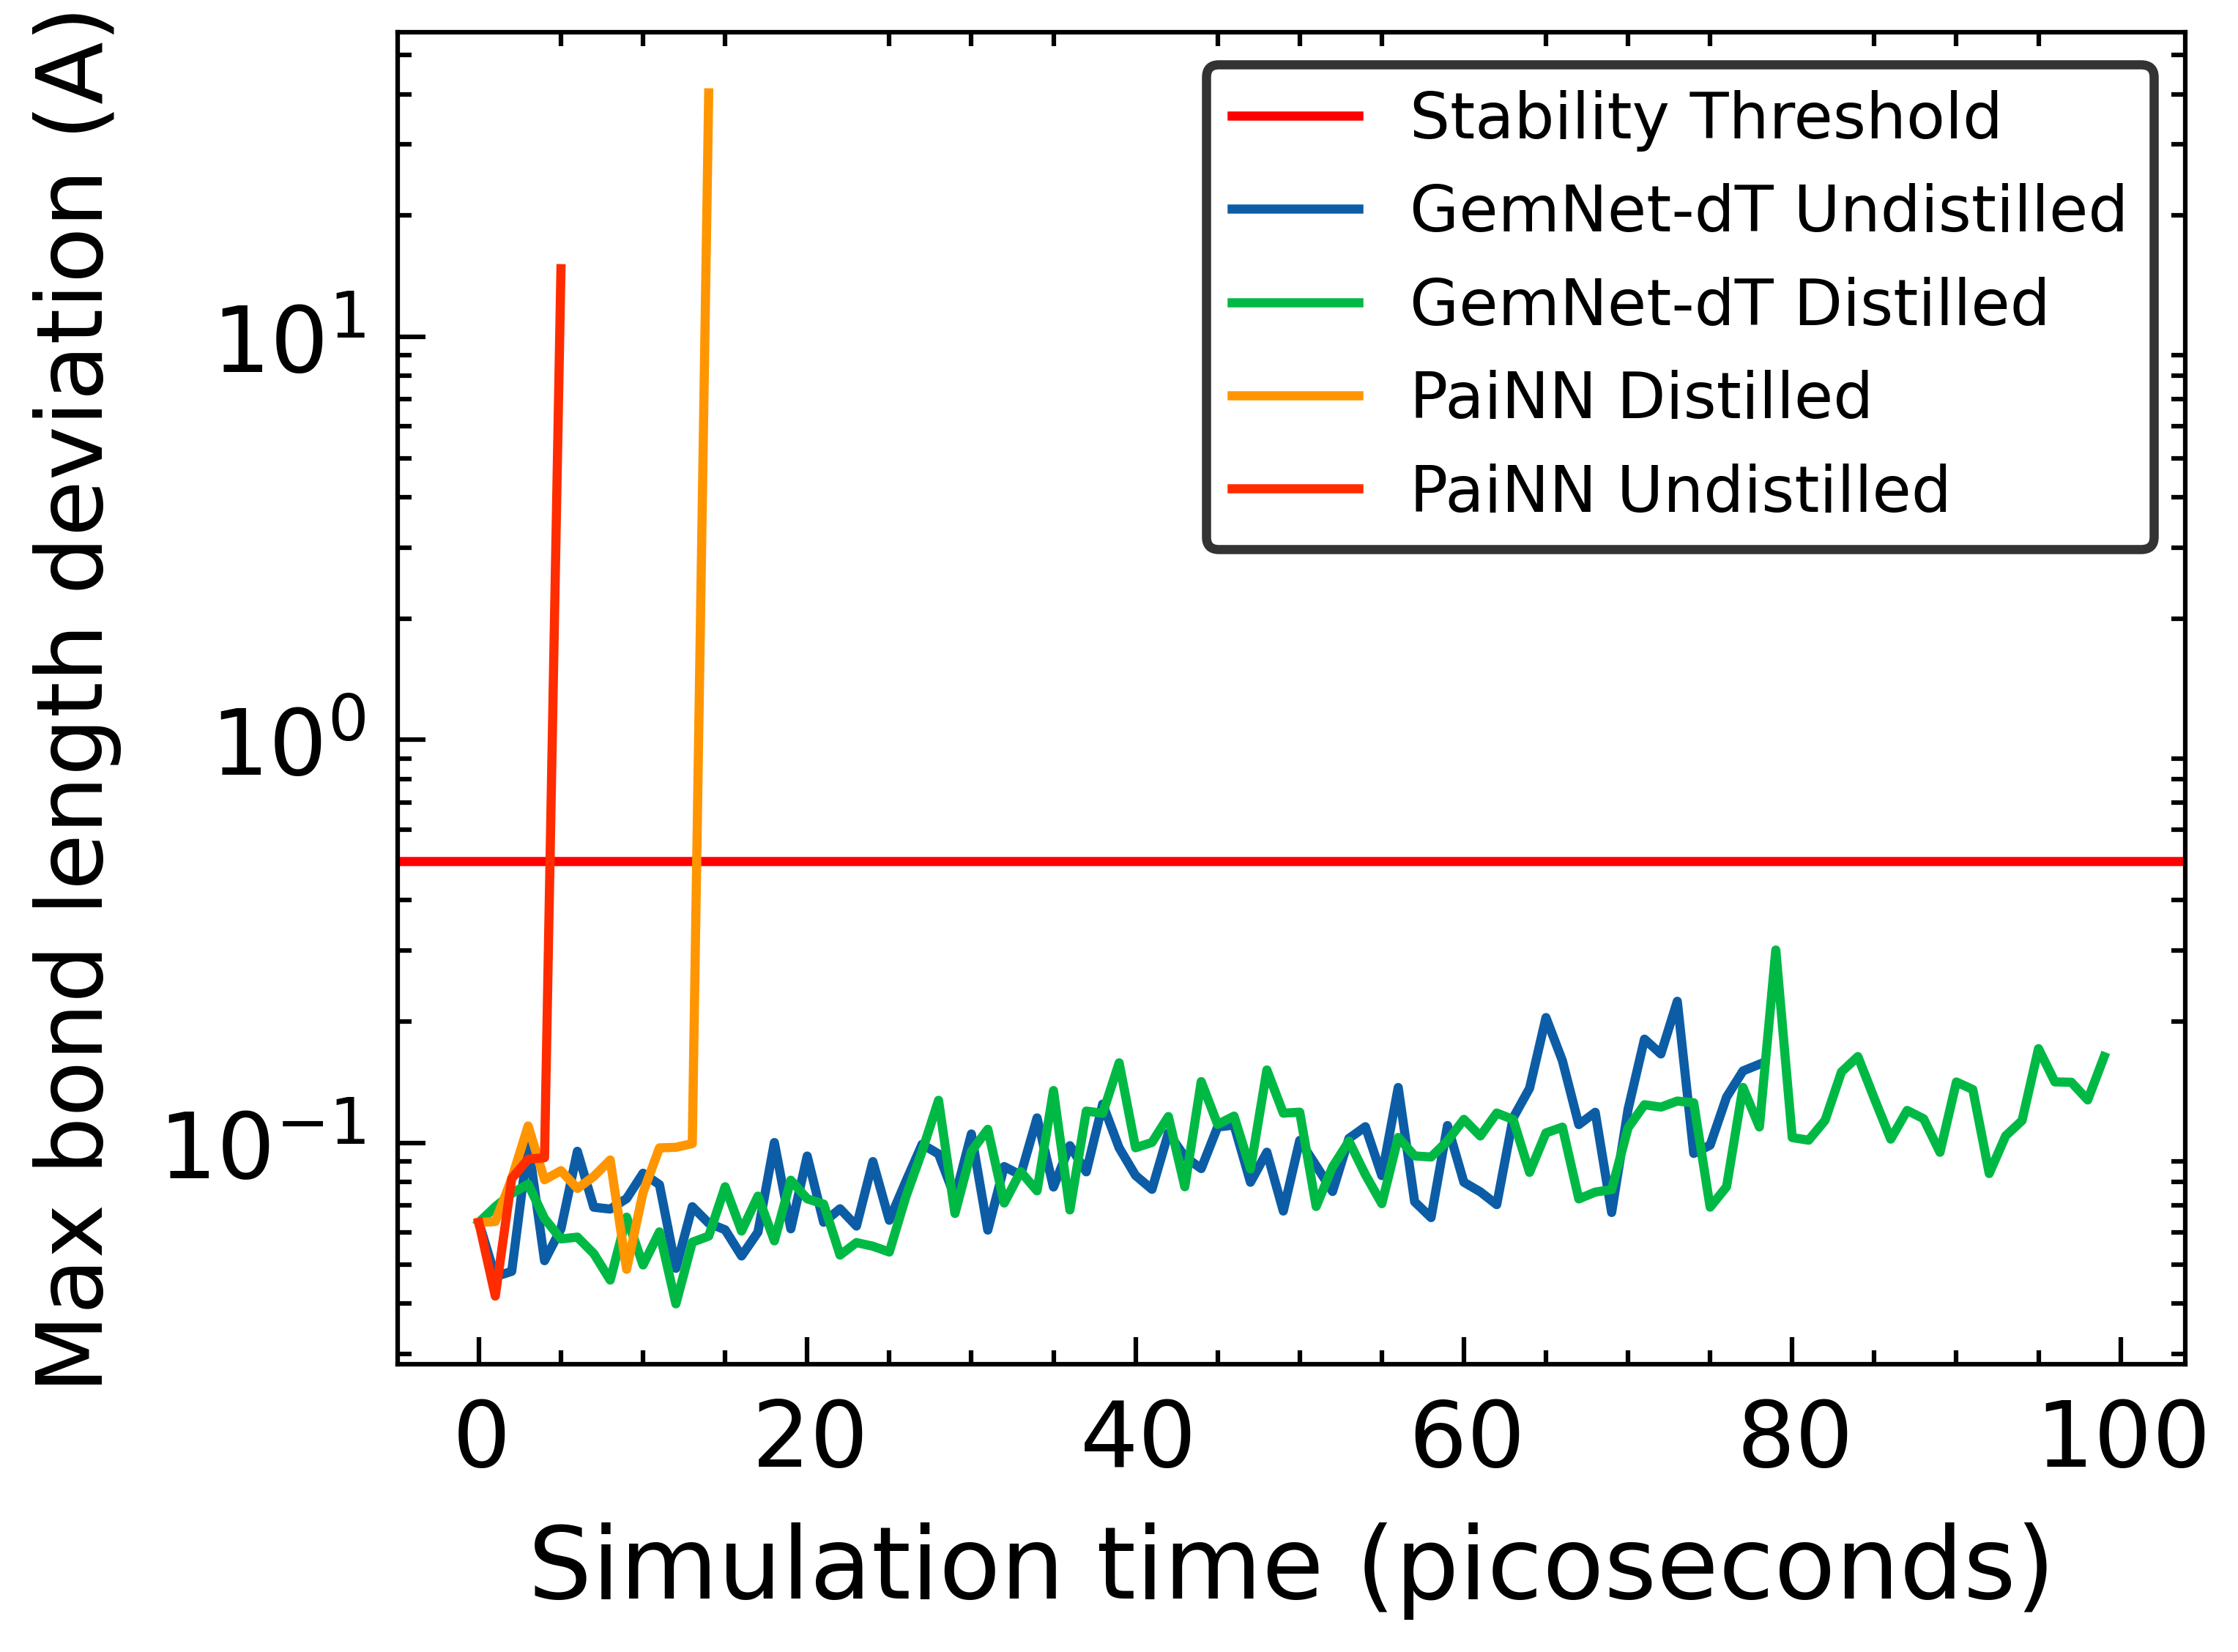

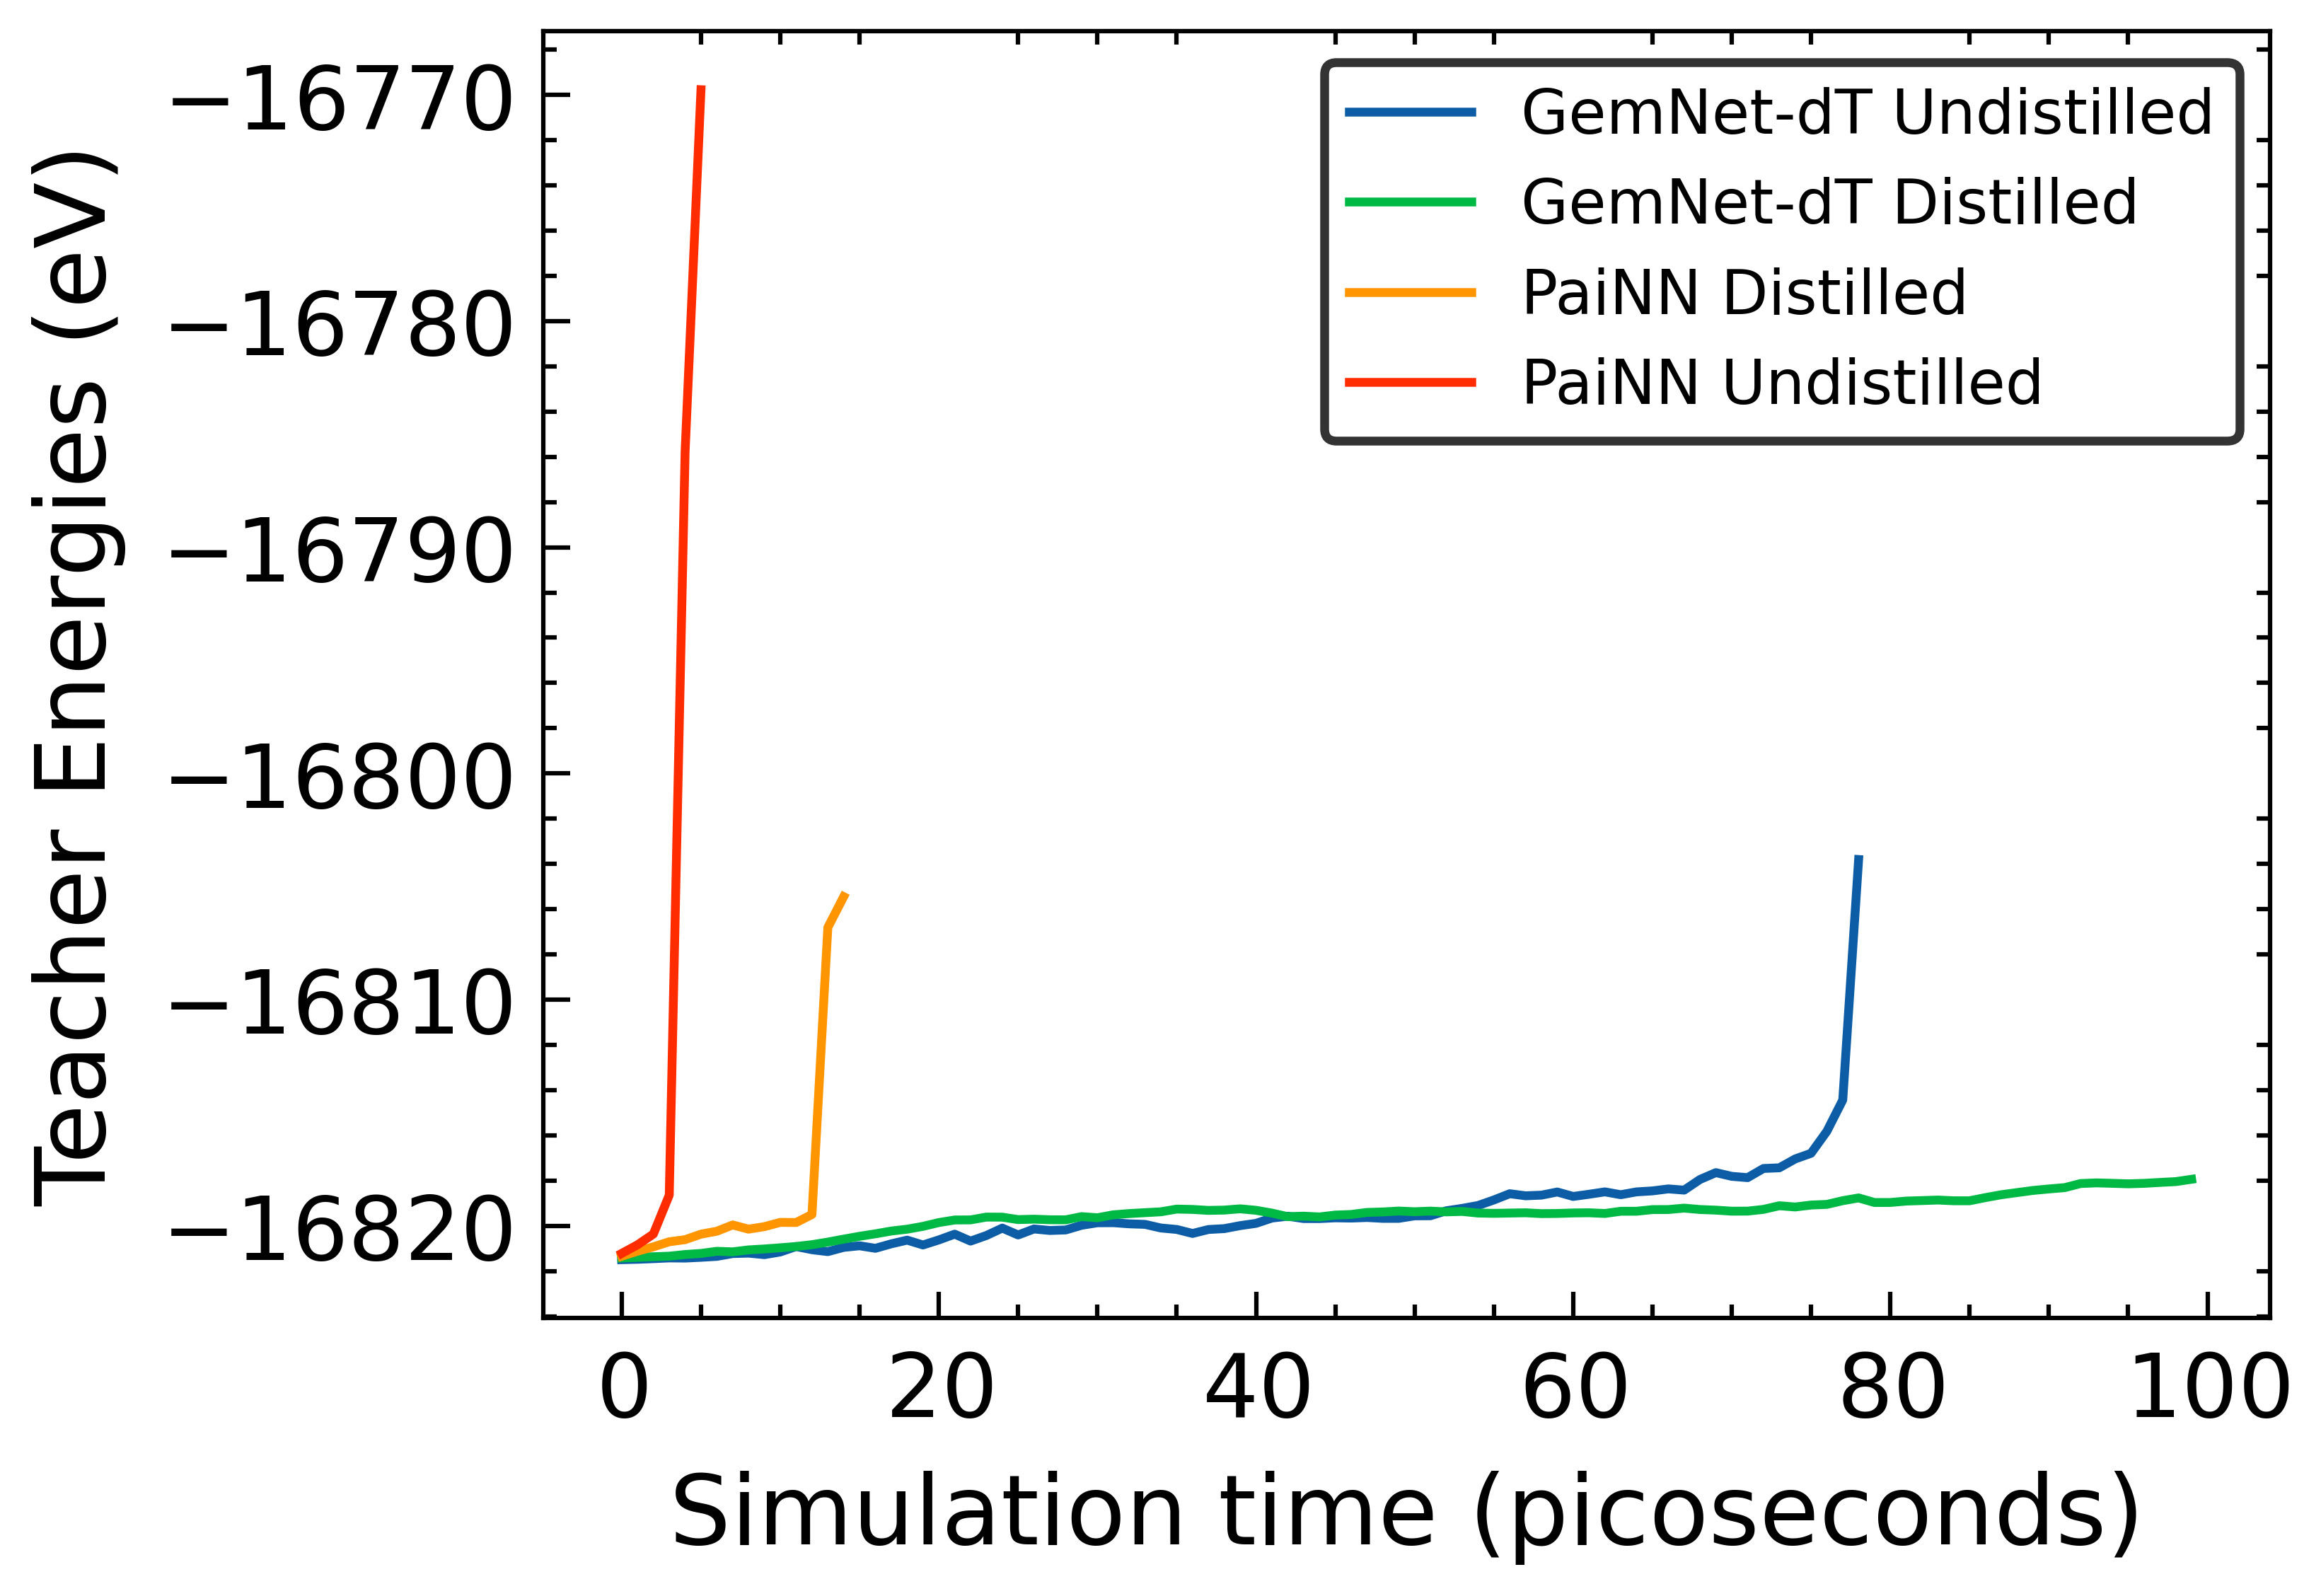

In [28]:
# Basic stability check on the trajectory (based on bond length deviations)
stability_threshold = 0.5
# Amino Acid runs

# data_split = "Solvated_Amino_Acids"
# md_dirs = ["2024-09-05-09-42-40-amino-gemSmall", "2024-09-05-13-45-52-solvated-gemSmall-DIST-4s", "2024-09-15-12-44-00-solvated_PaiNNpbc", "2024-09-15-14-45-36-solvated-Painn-DIST-pbc"]

# Monomer runs
data_split = "DES370K_Monomers" 
md_dirs = ["2024-09-05-00-08-48-monomers-gemSmall", "2024-09-05-09-04-16-monomers-gemSmall-DIST", "2024-09-08-10-33-52-monomers-PaiNN-DIST", "2024-09-08-10-25-20-monomers-PaiNN"]
plot_stability(data_split, md_dirs)